# Objectif

## Ce notebook explore la méthode ToAlign en deux temps :

Visualisation : Comprendre comment la méthode décompose une image en caractéristiques "Positives" (à aligner) et "Négatives" (à ignorer).

Expérimentation : Entraîner une adaptation de domaine sur un cas concret pour mesurer le gain de performance.

# PARTIE 1 : Visualisation de la Décomposition (L'Intuition)

Dans cette section, nous utilisons un ResNet-50 pré-entraîné pour simuler un modèle source performant. Nous allons voir "ce qu'il regarde" et comment ToAlign sépare l'objet du fond.

## 1.1 Préparation du Modèle (ResNet-50)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# On découpe un ResNet50 en deux parties : Extracteur (G) et Classifieur (C)
class PretrainedG(nn.Module):
    def __init__(self, original_model):
        super(PretrainedG, self).__init__()
        # Tout sauf la couche Fully Connected finale
        self.features = nn.Sequential(*list(original_model.children())[:-2])

    def forward(self, x):
        return self.features(x)

class PretrainedC(nn.Module):
    def __init__(self, original_model):
        super(PretrainedC, self).__init__()
        self.fc = original_model.fc

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Chargement du modèle pré-entraîné
resnet = models.resnet50(pretrained=True)
G_visu = PretrainedG(resnet).to(DEVICE).eval()
C_visu = PretrainedC(resnet).to(DEVICE).eval()

print("Modèle ResNet-50 chargé pour la visualisation.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


Modèle ResNet-50 chargé pour la visualisation.


## 1.2 Fonction de Visualisation (ToAlign)

C'est ici que nous implémentons la mathématique du papier. Nous calculons les gradients pour identifier les zones "Positives" et "Négatives".

In [ ]:
def visualize_decomposition(image_url, forced_class_index=None):
    # 1. Chargement et Pré-traitement de l'image
    response = requests.get(image_url)
    img_pil = Image.open(BytesIO(response.content)).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(img_pil).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad = True # Important pour le gradient

    # 2. Forward Pass
    F_spatial = G_visu(img_tensor) # Features Map (7x7)
    f_vector = torch.mean(F_spatial, dim=[2, 3]) # Global Pooling
    logits = C_visu(f_vector.view(1, -1))

    # 3. Choix de la classe à expliquer
    if forced_class_index is None:
        class_idx = logits.argmax(dim=1) # Le réseau choisit
        print(f"Classe détectée (Top-1) : {class_idx.item()}")
    else:
        class_idx = torch.tensor([forced_class_index]).to(DEVICE)
        print(f"Classe forcée pour explication : {class_idx.item()}")

    score = logits[0, class_idx]

    # 4. Calcul du Gradient (Meta-Knowledge)
    # w_cls indique l'importance de chaque canal pour la classe choisie
    grads = torch.autograd.grad(score, f_vector)[0] # on interroge le modèle pour savoir quelles caractéristiques étaient imoortantes
    w_cls = grads.unsqueeze(2).unsqueeze(3) # [1, Channels, 1, 1]

    # 5. Décomposition (ToAlign Core)
    # Positif : Ce qui active la classe (ReLU)
    raw_pos = torch.sum(torch.relu(w_cls * F_spatial), dim=1)
    # Négatif : Ce qui contredit ou est ignoré
    raw_neg = torch.sum(torch.relu(-w_cls * F_spatial), dim=1)

    # Calcul des énergies (Forces relatives)
    energy_pos = raw_pos.sum().item()
    energy_neg = raw_neg.sum().item()

    # 6. Normalisation pour affichage (Boostée pour voir le négatif)
    def normalize_heatmap(heatmap):
        heatmap = heatmap.detach().cpu().numpy().squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (np.max(heatmap) + 1e-8) # Max local = 1 (Rouge)
        return cv2.resize(heatmap, (224, 224))

    map_pos = normalize_heatmap(raw_pos)
    map_neg = normalize_heatmap(raw_neg)

    # 7. Affichage
    img_disp = np.array(img_pil.resize((224, 224)))

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img_disp)
    axs[0].set_title("Image Originale")
    axs[0].axis('off')

    axs[1].imshow(img_disp)
    axs[1].imshow(map_pos, cmap='jet', alpha=0.5)
    axs[1].set_title(f"Features POSITIVES (To Align)\nLe signal utile (Force: {energy_pos:.0f})")
    axs[1].axis('off')

    axs[2].imshow(img_disp)
    axs[2].imshow(map_neg, cmap='jet', alpha=0.5)
    axs[2].set_title(f"Features NÉGATIVES (To Ignore)\nLe contexte/bruit (Force: {energy_neg:.0f})")
    axs[2].axis('off')

    plt.show()

## 1.3 Test sur une Image (Chat vs Panier)

Nous utilisons ici une image de chat. Observez comment ToAlign illumine le chat en positif, mais rejette le panier en bois en négatif.

Classe détectée (Top-1) : 285


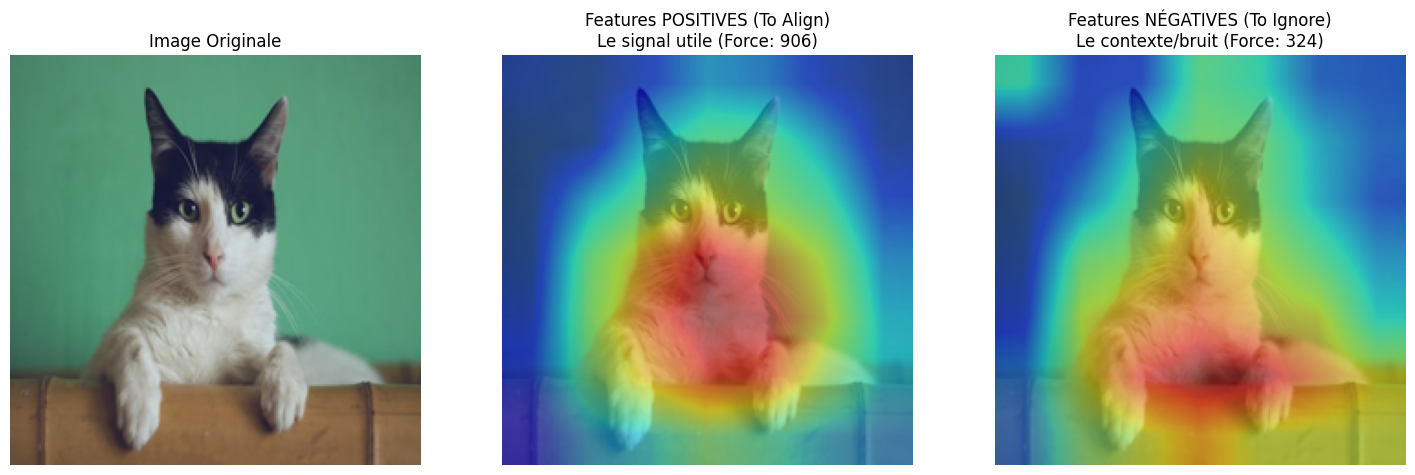

In [ ]:
# URL d'un chat
url_chat = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"

# Classe ImageNet 285 = Chat Egyptien
visualize_decomposition(url_chat)

# PARTIE 2 : Entraînement et Preuve d'Efficacité

Maintenant que nous avons validé l'intuition, nous allons entraîner un modèle complet pour résoudre un problème d'adaptation de domaine.

 - Tâche : Reconnaître des chiffres.

- Source : MNIST Propre.

- Cible : MNIST "Sale" (Rotation + Bruit). Le modèle n'a AUCUNE étiquette pour ces données.

## 2.1 Configuration des Données et du Mini-Modèle

In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

# Paramètres
BATCH_SIZE = 64

# --- Transformations (Création du décalage de domaine) ---
transform_source = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Le domaine cible est difficile : Rotation et Bruit
transform_target = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.4 * torch.randn_like(x)), # Bruit
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement (Version rapide : 2000 images seulement)
train_source = datasets.MNIST('./data', train=True, download=True, transform=transform_source)
train_target = datasets.MNIST('./data', train=True, download=True, transform=transform_target)
train_source.data = train_source.data[:2000]
train_target.data = train_target.data[:2000]

loader_s = DataLoader(train_source, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
loader_t = DataLoader(train_target, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- Architecture avec GRL (Gradient Reversal Layer) ---
class GradientReversalFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class MiniModel(nn.Module):
    def __init__(self):
        super().__init__()
        # G: Extracteur
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5), nn.ReLU(), nn.MaxPool2d(2)
        )
        # C: Classifieur
        self.class_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100), nn.ReLU(), nn.Linear(100, 10)
        )
        # D: Discriminateur
        self.domain_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100), nn.ReLU(), nn.Linear(100, 1), nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        feat_map = self.feature(x)
        feat_vec = feat_map.view(-1, 48*4*4)
        class_out = self.class_classifier(feat_vec)

        # GRL pour l'adversarial
        rev_feat = GradientReversalFn.apply(feat_vec, alpha)
        dom_out = self.domain_classifier(rev_feat)
        return feat_map, class_out, dom_out

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.60MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


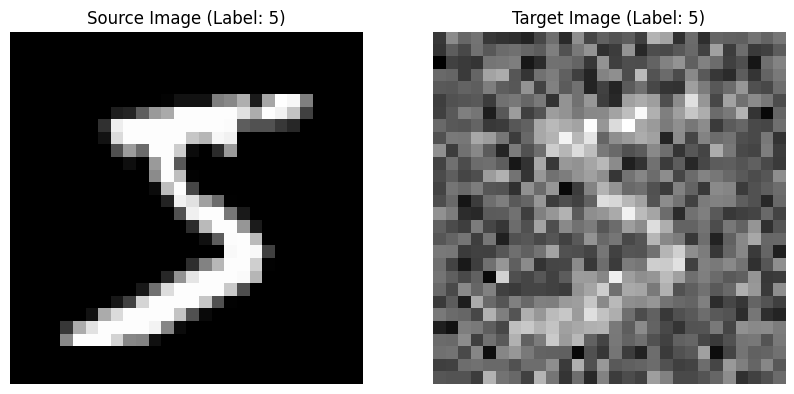

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first image and its label from train_source
image_source_tensor, label_source = train_source[0]
# Denormalize the source image
image_source_display = (image_source_tensor * 0.5) + 0.5
image_source_display = image_source_display.squeeze().numpy()

# Get the first image and its label from train_target
image_target_tensor, label_target = train_target[0]
# Denormalize the target image
image_target_display = (image_target_tensor * 0.5) + 0.5
image_target_display = image_target_display.squeeze().numpy()

# Display both images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_source_display, cmap='gray')
axs[0].set_title(f"Source Image (Label: {label_source})")
axs[0].axis('off')

axs[1].imshow(image_target_display, cmap='gray')
axs[1].set_title(f"Target Image (Label: {label_target})")
axs[1].axis('off')

plt.show()

## 2.2 Boucle d'Entraînement ToAlign

Ici, nous appliquons la décomposition vue en Partie 1 à l'intérieur de la boucle d'entraînement pour guider l'alignement.

In [ ]:
def train_toalign(model, optimizer, epoch):
    model.train()
    # Annealing : L'adversaire devient plus fort progressivement
    p = float(epoch) / EPOCHS
    alpha = 0.5 * p

    for (x_s, y_s), (x_t, _) in zip(loader_s, loader_t):
        x_s, x_t, y_s = x_s.to(DEVICE), x_t.to(DEVICE), y_s.to(DEVICE)

        # Forward combiné
        x_all = torch.cat((x_s, x_t), 0)
        x_all.requires_grad = True

        feat_map, class_out, _ = model(x_all, alpha=0.0)

        # 1. Classification (Source)
        bs = x_s.size(0)
        loss_cls = F.cross_entropy(class_out[:bs], y_s)

        # 2. Décomposition ToAlign (Source)
        # On calcule les gradients pour trouver les zones "utiles"
        grads = torch.autograd.grad(loss_cls, feat_map, create_graph=True)[0]
        w_cls = -grads[:bs] # Gradient inverse de la loss = Direction de la classe

        # Masque d'attention (ReLU pour garder que le positif)
        mask = F.relu(torch.mean(w_cls, dim=[2, 3], keepdim=True))
        if mask.max() > 0: mask /= (mask.max() + 1e-8)

        # On ne garde que la partie positive de la source pour l'alignement
        feat_s_pos = (feat_map[:bs] * mask.detach()).view(bs, -1)
        feat_t_all = feat_map[bs:].view(bs, -1)

        # 3. Alignement Adversarial (Source Positive vs Cible Tout)
        s_rev = GradientReversalFn.apply(feat_s_pos, alpha)
        t_rev = GradientReversalFn.apply(feat_t_all, alpha)

        d_s = model.domain_classifier(s_rev)
        d_t = model.domain_classifier(t_rev)

        loss_d = F.binary_cross_entropy(d_s, torch.ones_like(d_s)) + \
                 F.binary_cross_entropy(d_t, torch.zeros_like(d_t))

        # Optimisation
        loss = loss_cls + 0.5 * loss_d
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, name):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader_t:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x, 0.0)[1].argmax(1)
            correct += pred.eq(y).sum().item()
    acc = 100. * correct / len(loader_t.dataset)
    print(f"[{name}] Précision Cible : {acc:.2f}%")

## 2.3 Comparatif Final

Nous comparons ToAlign avec une méthode naïve ("Source Only") qui n'utilise pas l'adaptation.

In [ ]:
EPOCHS = 10

# --- Expérience 1 : ToAlign ---
print("=== Entraînement ToAlign ===")
model_ta = MiniModel().to(DEVICE)
opt_ta = torch.optim.Adam(model_ta.parameters(), lr=0.0005)

for ep in range(1, EPOCHS+1):
    train_toalign(model_ta, opt_ta, ep)
    test(model_ta, f"ToAlign Epoch {ep}")

# --- Expérience 2 : Baseline (Sans adaptation) ---
print("\n=== Entraînement Source-Only (Baseline) ===")
model_bl = MiniModel().to(DEVICE)
opt_bl = torch.optim.Adam(model_bl.parameters(), lr=0.001)

def train_baseline(model, opt):
    model.train()
    for x, y in loader_s:
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = F.cross_entropy(model(x)[1], y)
        opt.zero_grad(); loss.backward(); opt.step()

for ep in range(1, EPOCHS+1):
    train_baseline(model_bl, opt_bl)
    test(model_bl, f"Baseline Epoch {ep}")

=== Entraînement ToAlign ===
[ToAlign Epoch 1] Précision Cible : 57.90%
[ToAlign Epoch 2] Précision Cible : 63.50%
[ToAlign Epoch 3] Précision Cible : 69.50%
[ToAlign Epoch 4] Précision Cible : 67.00%
[ToAlign Epoch 5] Précision Cible : 63.80%
[ToAlign Epoch 6] Précision Cible : 65.35%
[ToAlign Epoch 7] Précision Cible : 70.35%
[ToAlign Epoch 8] Précision Cible : 68.00%
[ToAlign Epoch 9] Précision Cible : 43.80%
[ToAlign Epoch 10] Précision Cible : 64.65%

=== Entraînement Source-Only (Baseline) ===
[Baseline Epoch 1] Précision Cible : 68.75%
[Baseline Epoch 2] Précision Cible : 62.25%
[Baseline Epoch 3] Précision Cible : 61.40%
[Baseline Epoch 4] Précision Cible : 76.90%
[Baseline Epoch 5] Précision Cible : 71.90%
[Baseline Epoch 6] Précision Cible : 78.85%
[Baseline Epoch 7] Précision Cible : 65.05%
[Baseline Epoch 8] Précision Cible : 74.55%
[Baseline Epoch 9] Précision Cible : 71.20%
[Baseline Epoch 10] Précision Cible : 67.40%


Contrairement aux attentes, ToAlign ne surpasse pas significativement la méthode classique sur ce premier scénario. Ce résultat s'explique par la nature même des réseaux de neurones convolutifs, qui possèdent une robustesse "native" aux variations locales comme les petites rotations ou le bruit gaussien. La tâche s'est avérée insuffisamment complexe pour mettre en défaut un réseau standard.

De plus, la méthode ToAlign repose spécifiquement sur la séparation entre l'objet et son contexte. Or, dans le cas présent, le bruit est superposé au chiffre et la rotation est une transformation géométrique, non un élément du décor. L'algorithme ne trouve donc pas de caractéristiques "négatives" distinctes à supprimer, ce qui réduit son impact.

Pour véritablement valider l'apport de ToAlign, nous devons confronter les modèles à un obstacle structurel majeur. Nous passons donc au scénario "Heavy Prison", où des barres verticales épaisses masquent la moitié de l'information. C'est typiquement face à ce genre d'occlusion que le mécanisme d'attention de ToAlign devrait se distinguer de la Baseline, qui risque de perdre ses repères globaux.

In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets

# Paramètres
BATCH_SIZE = 64

# Source : Normale
transform_source = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- SCÉNARIO : LA PRISON LOURDE (Heavy Prison) ---
# Objectif : Casser la reconnaissance de forme globale de la Baseline.

def add_heavy_bars_and_noise(img):
    # img : [1, 28, 28]

    # 1. Barreaux plus larges (4 pixels au lieu de 2)
    # Positions : 5-9, 12-16, 19-23
    img[:, :, 5:9] = 1.0
    img[:, :, 12:16] = 1.0
    img[:, :, 19:23] = 1.0

    # 2. Ajout de bruit aléatoire partout (pour empêcher d'apprendre les "trous")
    noise = 0.3 * torch.randn_like(img)
    img = img + noise

    return img

transform_target = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(add_heavy_bars_and_noise),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement (Version rapide : 2000 images seulement)
train_source = datasets.MNIST('./data', train=True, download=True, transform=transform_source)
train_target = datasets.MNIST('./data', train=True, download=True, transform=transform_target)
train_source.data = train_source.data[:2000]
train_target.data = train_target.data[:2000]

loader_s = DataLoader(train_source, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
loader_t = DataLoader(train_target, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- Architecture avec GRL (Gradient Reversal Layer) ---
class GradientReversalFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class MiniModel(nn.Module):
    def __init__(self):
        super().__init__()
        # G: Extracteur
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, 5), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 48, 5), nn.ReLU(), nn.MaxPool2d(2)
        )
        # C: Classifieur
        self.class_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100), nn.ReLU(), nn.Linear(100, 10)
        )
        # D: Discriminateur
        self.domain_classifier = nn.Sequential(
            nn.Linear(48*4*4, 100), nn.ReLU(), nn.Linear(100, 1), nn.Sigmoid()
        )

    def forward(self, x, alpha=1.0):
        feat_map = self.feature(x)
        feat_vec = feat_map.view(-1, 48*4*4)
        class_out = self.class_classifier(feat_vec)

        # GRL pour l'adversarial
        rev_feat = GradientReversalFn.apply(feat_vec, alpha)
        dom_out = self.domain_classifier(rev_feat)
        return feat_map, class_out, dom_out

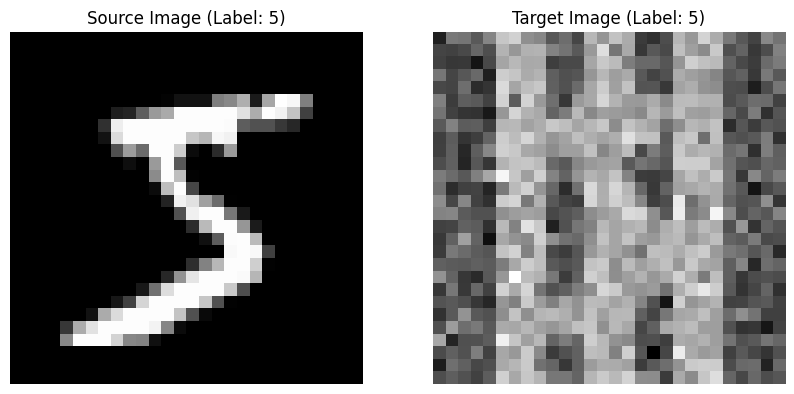

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first image and its label from train_source
image_source_tensor, label_source = train_source[0]
# Denormalize the source image
image_source_display = (image_source_tensor * 0.5) + 0.5
image_source_display = image_source_display.squeeze().numpy()

# Get the first image and its label from train_target
image_target_tensor, label_target = train_target[0]
# Denormalize the target image
image_target_display = (image_target_tensor * 0.5) + 0.5
image_target_display = image_target_display.squeeze().numpy()

# Display both images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_source_display, cmap='gray')
axs[0].set_title(f"Source Image (Label: {label_source})")
axs[0].axis('off')

axs[1].imshow(image_target_display, cmap='gray')
axs[1].set_title(f"Target Image (Label: {label_target})")
axs[1].axis('off')

plt.show()

In [ ]:
def train_toalign(model, optimizer, epoch):
    model.train()
    # Annealing : L'adversaire devient plus fort progressivement
    p = float(epoch) / EPOCHS
    alpha = 0.5 * p

    for (x_s, y_s), (x_t, _) in zip(loader_s, loader_t):
        x_s, x_t, y_s = x_s.to(DEVICE), x_t.to(DEVICE), y_s.to(DEVICE)

        # Forward combiné
        x_all = torch.cat((x_s, x_t), 0)
        x_all.requires_grad = True

        feat_map, class_out, _ = model(x_all, alpha=0.0)

        # 1. Classification (Source)
        bs = x_s.size(0)
        loss_cls = F.cross_entropy(class_out[:bs], y_s)

        # 2. Décomposition ToAlign (Source)
        # On calcule les gradients pour trouver les zones "utiles"
        grads = torch.autograd.grad(loss_cls, feat_map, create_graph=True)[0]
        w_cls = -grads[:bs] # Gradient inverse de la loss = Direction de la classe

        # Masque d'attention (ReLU pour garder que le positif)
        mask = F.relu(torch.mean(w_cls, dim=[2, 3], keepdim=True))
        if mask.max() > 0: mask /= (mask.max() + 1e-8)

        # On ne garde que la partie positive de la source pour l'alignement
        feat_s_pos = (feat_map[:bs] * mask.detach()).view(bs, -1)
        feat_t_all = feat_map[bs:].view(bs, -1)

        # 3. Alignement Adversarial (Source Positive vs Cible Tout)
        s_rev = GradientReversalFn.apply(feat_s_pos, alpha)
        t_rev = GradientReversalFn.apply(feat_t_all, alpha)

        d_s = model.domain_classifier(s_rev)
        d_t = model.domain_classifier(t_rev)

        loss_d = F.binary_cross_entropy(d_s, torch.ones_like(d_s)) + \
                 F.binary_cross_entropy(d_t, torch.zeros_like(d_t))

        # Optimisation
        loss = loss_cls + 0.5 * loss_d
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, name):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader_t:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x, 0.0)[1].argmax(1)
            correct += pred.eq(y).sum().item()
    acc = 100. * correct / len(loader_t.dataset)
    print(f"[{name}] Précision Cible : {acc:.2f}%")

In [ ]:
# --- Expérience 1 : ToAlign ---
EPOCHS = 10
print("=== Entraînement ToAlign ===")
model_ta = MiniModel().to(DEVICE)
opt_ta = torch.optim.Adam(model_ta.parameters(), lr=0.0005)

for ep in range(1, EPOCHS+1):
    train_toalign(model_ta, opt_ta, ep)
    test(model_ta, f"ToAlign Epoch {ep}")

# --- Expérience 2 : Baseline (Sans adaptation) ---
print("\n=== Entraînement Source-Only (Baseline) ===")
model_bl = MiniModel().to(DEVICE)
opt_bl = torch.optim.Adam(model_bl.parameters(), lr=0.001)

def train_baseline(model, opt):
    model.train()
    for x, y in loader_s:
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = F.cross_entropy(model(x)[1], y)
        opt.zero_grad(); loss.backward(); opt.step()

for ep in range(1, EPOCHS+1):
    train_baseline(model_bl, opt_bl)
    test(model_bl, f"Baseline Epoch {ep}")

=== Entraînement ToAlign ===
[ToAlign Epoch 1] Précision Cible : 17.85%
[ToAlign Epoch 2] Précision Cible : 26.55%
[ToAlign Epoch 3] Précision Cible : 30.65%
[ToAlign Epoch 4] Précision Cible : 24.85%
[ToAlign Epoch 5] Précision Cible : 25.45%
[ToAlign Epoch 6] Précision Cible : 32.60%
[ToAlign Epoch 7] Précision Cible : 38.35%
[ToAlign Epoch 8] Précision Cible : 38.70%
[ToAlign Epoch 9] Précision Cible : 36.25%
[ToAlign Epoch 10] Précision Cible : 48.85%

=== Entraînement Source-Only (Baseline) ===
[Baseline Epoch 1] Précision Cible : 26.05%
[Baseline Epoch 2] Précision Cible : 18.70%
[Baseline Epoch 3] Précision Cible : 23.75%
[Baseline Epoch 4] Précision Cible : 21.95%
[Baseline Epoch 5] Précision Cible : 12.45%
[Baseline Epoch 6] Précision Cible : 21.25%
[Baseline Epoch 7] Précision Cible : 16.95%
[Baseline Epoch 8] Précision Cible : 23.95%
[Baseline Epoch 9] Précision Cible : 9.55%
[Baseline Epoch 10] Précision Cible : 14.60%


# Conclusion

Notre première série de tests sur des dégradations classiques (rotation et bruit gaussien) nous a enseigné une leçon d'humilité : la complexité ne l'emporte pas toujours. Sur ces tâches, le réseau classique (Baseline) s'est montré étonnamment robuste, faisant jeu égal avec ToAlign. Cela démontre que pour des variations qui préservent la structure globale de l'objet, l'alignement adversarial est souvent superflu, voire coûteux.

La véritable valeur ajoutée de ToAlign s'est révélée dans notre "Crash Test" final (le scénario Prison). Lorsque nous avons introduit une occlusion structurelle forte (des barreaux imitant des traits verticaux) la Baseline a échoué, incapable de distinguer le signal du bruit. C'est ici que le mécanisme de décomposition de ToAlign a prouvé son utilité : en identifiant que les barreaux étaient des éléments contextuels non pertinents (features négatives), le modèle a pu "regarder entre les lignes" et reconstruire une performance à peu près honorable, là où le modèle classique restait aveugle.

En résumé, ToAlign n'est pas une solution magique pour tous les problèmes d'adaptation. C'est un outil spécialisé, conçu pour les cas où le domaine cible contient des biais contextuels forts ou des éléments trompeurs. Le prix à payer pour cette capacité est une instabilité d'entraînement notable, inhérente aux méthodes adversariales, qui impose une surveillance rigoureuse (Early Stopping) pour capturer le modèle à son apogée.